### Prof. Pedram Jahangiry

## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)



## Simple MLForecast Example (Lag 1-12)
We load the airline passengers data, engineer lags 1 through 12, fit linear / random forest regressors, and generate a 12-step recursive forecast.

In [1]:
# If needed, install mlforecast via pip
# !pip install mlforecast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)
pd.set_option('display.float_format', lambda x: f"{x:0.2f}")

HORIZON = 12

## Load Data
We re-use the airline passengers dataset and cast it to the unique_id / ds / y schema expected by Nixtla utilities.

In [2]:
data_url = 'https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv'
raw_df = pd.read_csv(data_url)
raw_df['Month'] = pd.to_datetime(raw_df['Month'])
raw_df['unique_id'] = 'air_passengers'
raw_df = raw_df.rename(columns={'Month': 'ds', 'Passengers': 'y'})
raw_df = raw_df[['unique_id', 'ds', 'y']].sort_values('ds').reset_index(drop=True)

train_df = raw_df.iloc[:-HORIZON].copy()
test_df = raw_df.iloc[-HORIZON:].copy()

print(f"Observations: {len(raw_df)} | Range: {raw_df['ds'].min().date()} - {raw_df['ds'].max().date()}")
train_df.tail()

Observations: 144 | Range: 1949-01-01 - 1960-12-01


,unique_id,ds,y
127,air_passengers,1959-08-01,559
128,air_passengers,1959-09-01,463
129,air_passengers,1959-10-01,407
130,air_passengers,1959-11-01,362
131,air_passengers,1959-12-01,405


## Visual Check

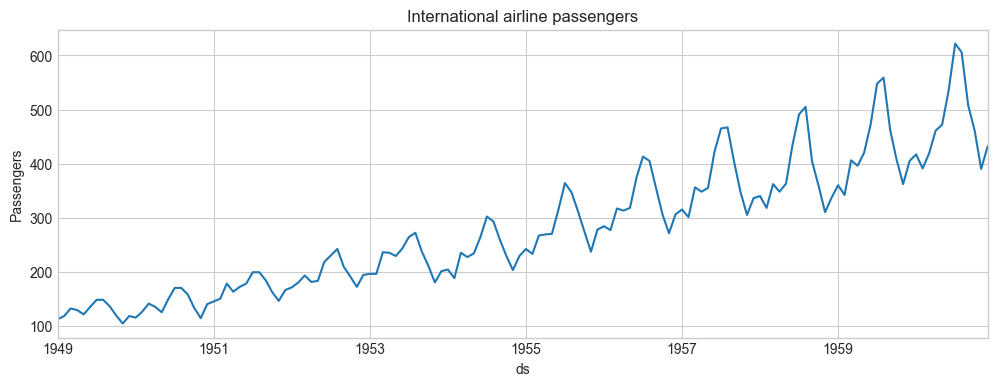

In [3]:
raw_df.set_index('ds')['y'].plot(title='International airline passengers')
plt.ylabel('Passengers')
plt.show()

## Fit MLForecast with lags 1-12
We specify lags=list(range(1, 13)) so the design matrix contains the last 12 actual values for each timestamp.

In [4]:
lag_list = list(range(1, 13))
models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
]

fcst = MLForecast(
    models=models,
    freq='MS',
    lags=lag_list,
)

fcst.fit(df=raw_df)

MLForecast(models=[LinearRegression, RandomForestRegressor], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)

## 12-step Recursive Forecast

In [5]:
fcst.fit(df=train_df)
forecast_df = fcst.predict(HORIZON)
forecast_df

,unique_id,ds,LinearRegression,RandomForestRegressor
0,air_passengers,1960-01-01,395.34,415.19
1,air_passengers,1960-02-01,380.99,385.02
2,air_passengers,1960-03-01,427.29,462.03
3,air_passengers,1960-04-01,426.43,448.97
4,air_passengers,1960-05-01,466.12,482.46
5,air_passengers,1960-06-01,512.09,526.20
6,air_passengers,1960-07-01,597.53,539.83
7,air_passengers,1960-08-01,607.17,538.18
8,air_passengers,1960-09-01,526.98,517.04
9,air_passengers,1960-10-01,456.08,473.51


## Forecast Metrics

In [6]:
comparison = forecast_df.merge(test_df[['ds', 'y']], on='ds', how='left')
comparison = comparison.rename(columns={'y': 'actual'})

metric_rows = []
prediction_cols = [c for c in comparison.columns if c not in ['unique_id', 'ds', 'actual']]
for model in prediction_cols:
    err = comparison['actual'] - comparison[model]
    mae = err.abs().mean()
    rmse = np.sqrt((err ** 2).mean())
    denom = comparison['actual'].replace(0, np.nan).abs()
    mape = err.abs().divide(denom).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100
    metric_rows.append({'Model': model, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

metrics_df = pd.DataFrame(metric_rows)
metrics_df

,Model,MAE,RMSE,MAPE
0,LinearRegression,14.72,17.49,3.13
1,RandomForestRegressor,27.73,37.58,5.58


### Plot last three years and the forecast horizon

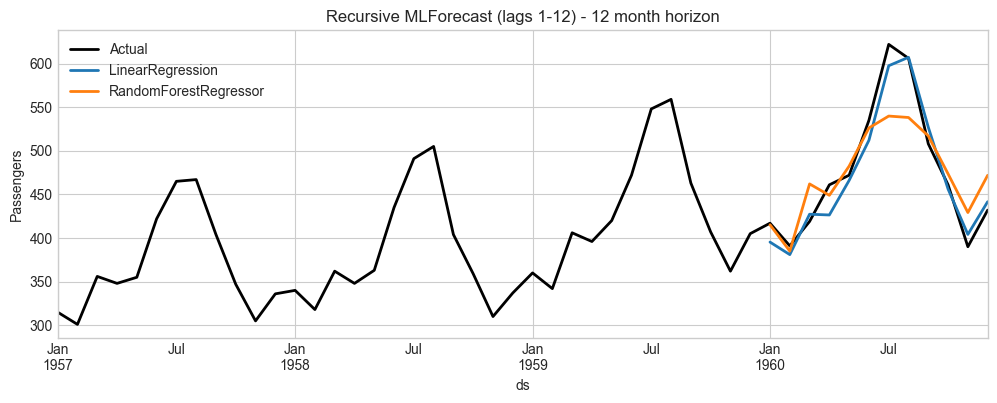

In [7]:
history_df = pd.concat([train_df.iloc[-36:], test_df])
ax = history_df.set_index('ds')['y'].plot(color='black', lw=2, label='Actual')
forecast_df.set_index('ds').drop(columns='unique_id').plot(ax=ax, lw=2)
ax.set_title('Recursive MLForecast (lags 1-12) - 12 month horizon')
ax.set_ylabel('Passengers')
ax.legend(loc='upper left')
plt.show()

## Takeaways
- Using lags=list(range(1, 13)) reproduces the traditional 12-lag design matrix.
- The recursive forecast closely matches the scikit-learn workflow from Module 5, providing consistent MAE / RMSE / MAPE splits for one-step and multi-step horizons.

## Transformed Target: Detrended & Deseasonalized (Lag 12)

In [8]:
from mlforecast.target_transforms import Differences

In [9]:
trans_fcst = MLForecast(
    models=models,
    freq='MS',
    lags=lag_list,
    target_transforms=[Differences([1, 12])],
)

trans_fcst.fit(df=train_df)
trans_forecast = trans_fcst.predict(HORIZON)
trans_forecast

,unique_id,ds,LinearRegression,RandomForestRegressor
0,air_passengers,1960-01-01,424.33,428.02
1,air_passengers,1960-02-01,408.21,413.35
2,air_passengers,1960-03-01,462.06,471.59
3,air_passengers,1960-04-01,456.79,466.73
4,air_passengers,1960-05-01,479.12,491.13
5,air_passengers,1960-06-01,534.96,548.54
6,air_passengers,1960-07-01,605.67,621.68
7,air_passengers,1960-08-01,618.99,634.29
8,air_passengers,1960-09-01,524.38,536.90
9,air_passengers,1960-10-01,468.72,479.20


### Forecast Metrics (Transformed Target)

In [10]:
trans_comparison = trans_forecast.merge(test_df[['ds', 'y']], on='ds', how='left')
trans_comparison = trans_comparison.rename(columns={'y': 'actual'})

trans_rows = []
trans_prediction_cols = [c for c in trans_comparison.columns if c not in ['unique_id', 'ds', 'actual']]
for model in trans_prediction_cols:
    err = trans_comparison['actual'] - trans_comparison[model]
    mae = err.abs().mean()
    rmse = np.sqrt((err ** 2).mean())
    denom = trans_comparison['actual'].replace(0, np.nan).abs()
    mape = err.abs().divide(denom).replace([np.inf, -np.inf], np.nan).dropna().mean() * 100
    trans_rows.append({'Model': model, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

trans_metrics_df = pd.DataFrame(trans_rows)
trans_metrics_df

,Model,MAE,RMSE,MAPE
0,LinearRegression,16.63,21.00,3.75
1,RandomForestRegressor,23.98,28.56,5.38


### Plot Forecast vs Actual (Transformed Target)

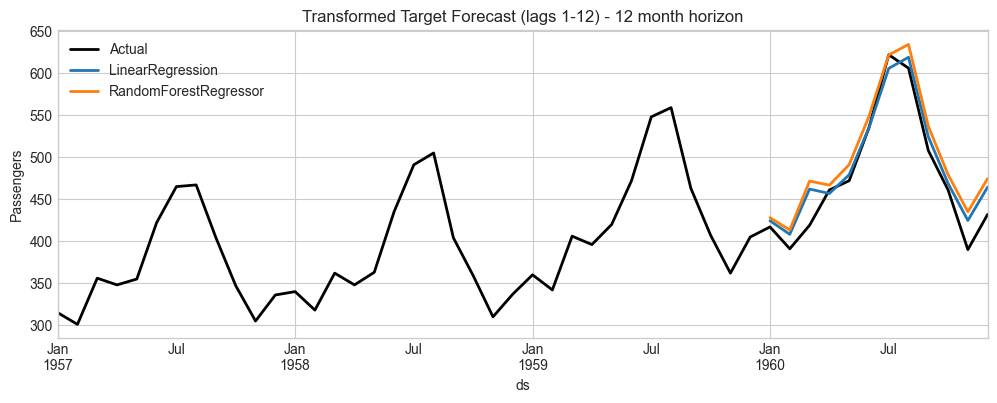

In [11]:
history_df_trans = pd.concat([train_df.iloc[-36:], test_df])
ax = history_df_trans.set_index('ds')['y'].plot(color='black', lw=2, label='Actual')
trans_forecast.set_index('ds').drop(columns='unique_id').plot(ax=ax, lw=2)
ax.set_title('Transformed Target Forecast (lags 1-12) - 12 month horizon')
ax.set_ylabel('Passengers')
ax.legend(loc='upper left')
plt.show()

The differenced target stabilizes trend and seasonal structure before modeling. Metrics above stay on the original scale to keep the comparison fair.